In [1]:
# Install necessary packages
!pip install tensorflow numpy matplotlib pandas scikit-learn kagglehub pillow seaborn

In [2]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Download and Prepare Dataset

We'll use a fire detection dataset from Kaggle that includes images of fire and non-fire scenes.

In [3]:
# Download the Forest Fire Detection dataset using kagglehub
# You need to authenticate with kaggle first: run 'kaggle authenticate' in terminal
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /kaggle/input/the-wildfire-dataset


In [4]:
# Define paths to dataset directories
# Adjust these paths based on your dataset structure
DATA_DIR = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version'
!ls -la {DATA_DIR}

total 0
drwxr-sr-x 5 1000 1000 0 Apr  9 09:17 .
drwxr-sr-x 3 1000 1000 0 Apr  9 09:19 ..
drwxr-sr-x 4 1000 1000 0 Apr  9 09:15 test
drwxr-sr-x 4 1000 1000 0 Apr  9 09:15 train
drwxr-sr-x 4 1000 1000 0 Apr  9 09:17 val


In [7]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data directories
train_dir = os.path.join(DATA_DIR, 'train')  # Update with your actual path
val_dir = os.path.join(DATA_DIR, 'val')      # Update with your actual path
test_dir = os.path.join(DATA_DIR, 'test')    # Update with your actual path

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data should only be rescaled
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Flow validation images in batches
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Flow test images in batches
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


## View Sample Images

Let's visualize some samples from our dataset to understand what we're working with.

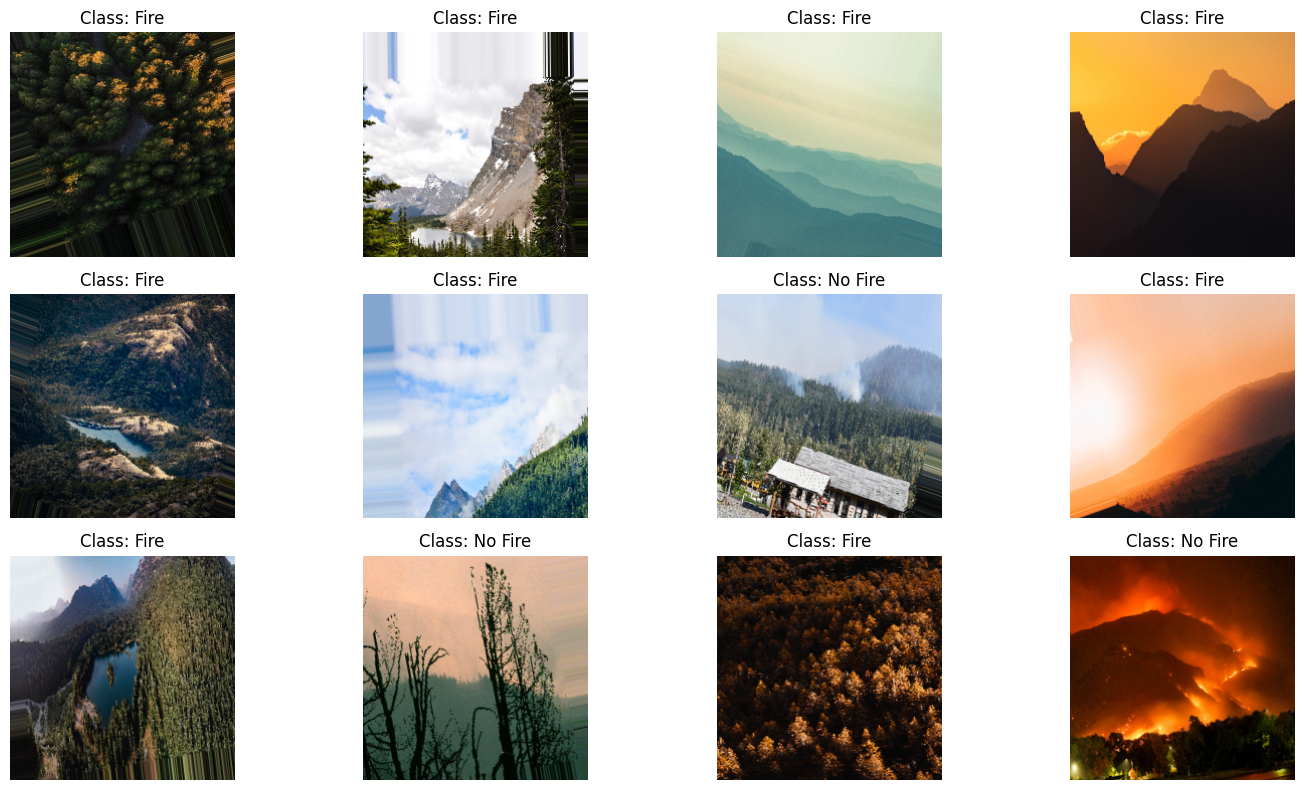

In [8]:
# Get a batch of training images
images, labels = next(train_generator)

# Display sample images
plt.figure(figsize=(15, 8))
for i in range(min(12, len(images))):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {'Fire' if labels[i] > 0.5 else 'No Fire'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Build Individual CNN Models

We'll create three different CNN models using pre-trained architectures (VGG16, ResNet50, and InceptionV3) as base models.

In [9]:
def create_cnn_model(base_model_name, trainable=False):
    """Create a CNN model based on a pre-trained architecture

    Args:
        base_model_name (str): Name of the pre-trained model to use ('vgg16', 'resnet50', or 'inception')
        trainable (bool): Whether to make the base model trainable

    Returns:
        A Keras model
    """
    # Define input shape
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

    # Create base model
    if base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'inception':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model name: {base_model_name}")

    # Freeze the base model if not trainable
    base_model.trainable = trainable

    # Add classification head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

## Train Individual Models

Now we'll train each individual CNN model separately.

In [10]:
# Define callbacks
def create_callbacks(model_name):
    checkpoint = ModelCheckpoint(
        f'models/{model_name}_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]

# Create directory for saving models
os.makedirs('models', exist_ok=True)

In [11]:
from google.colab import files

In [ ]:
# Train VGG16 model
print("Training VGG16 model...")
vgg_model = create_cnn_model('vgg16')
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=create_callbacks('vgg16')
)
vgg_model.save("vgg16_model.keras")
files.download("vgg16_model.keras")

Training VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
# Train ResNet50 model
print("Training ResNet50 model...")
resnet_model = create_cnn_model('resnet50')
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=create_callbacks('resnet50')
)
resnet_model.save("resnet50_model_1.keras")
files.download("resnet50_model_1.keras")

In [ ]:
# Train InceptionV3 model
print("Training InceptionV3 model...")
inception_model = create_cnn_model('inception')
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=create_callbacks('inception')
)
inception_model.save("inception_model.keras")
files.download("inception_model.keras")

## Evaluate Individual Models

Let's evaluate the performance of each individual model.

In [ ]:
def evaluate_model(model, model_name):
    # Load the best saved model
    model = load_model(f'models/{model_name}_best.h5')

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

    # Predict on test set
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    y_true = test_generator.classes

    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Fire', 'Fire'],
                yticklabels=['No Fire', 'Fire'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['No Fire', 'Fire']))

    return y_pred

In [ ]:
from tensorflow import keras

# Load the model
vgg_model = keras.models.load_model("vgg16_model.keras")
resnet_model = keras.models.load_model("resnet50_model.keras")
inception_model = keras.models.load_model("inception_model.keras")

In [ ]:
# Evaluate each model
vgg_preds = evaluate_model(vgg_model, 'vgg16')
resnet_preds = evaluate_model(resnet_model, 'resnet50')
inception_preds = evaluate_model(inception_model, 'inception')

## Simple Voting Ensemble

As an alternative, we can also implement a simple voting mechanism without training a meta-model.

In [ ]:
# Implement simple voting ensemble (average predictions)
voting_preds = (vgg_preds + resnet_preds + inception_preds) / 3
voting_classes = (voting_preds > 0.5).astype("int32")

# Get test labels
test_generator.reset()
y_true = test_generator.classes

# Calculate accuracy
voting_acc = accuracy_score(y_true, voting_classes)
print(f"Voting Ensemble Accuracy: {voting_acc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, voting_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fire', 'Fire'],
            yticklabels=['No Fire', 'Fire'])
plt.title('Voting Ensemble Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nVoting Ensemble Classification Report:")
print(classification_report(y_true, voting_classes, target_names=['No Fire', 'Fire']))

## Compare Model Performance

Let's compare the performance of all models.

In [ ]:
# Load histories
def plot_training_history(histories, model_names):
    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot all learning curves
plot_training_history(
    [vgg_history, resnet_history, inception_history],
    ['VGG16', 'ResNet50', 'InceptionV3']
)

## Test the Model on New Images

Finally, let's test our model on some new images.

In [ ]:
def predict_image(model, img_path):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make prediction
    prediction = model.predict(img_array)[0][0]
    class_name = 'Fire' if prediction > 0.5 else 'No Fire'

    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {class_name} ({prediction:.4f})')
    plt.axis('off')
    plt.show()

    return class_name, prediction


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


fire_image = os.path.join(test_dir, 'fire/27968020506_5f1a59f2a5_o.jpg')
non_fire_image = os.path.join(test_dir, 'nofire/33696343816_811bd98925_o.jpg')

fire_img = mpimg.imread(fire_image)
non_fire_img = mpimg.imread(non_fire_image)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(fire_img)
plt.title("Fire Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_fire_img)
plt.title("Non-Fire Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
vgg_prediction = predict_image(vgg_model, fire_image)
vgg_prediction_non_fire = predict_image(vgg_model, non_fire_image)
resnet_prediction = predict_image(resnet_model, fire_image)
resnet_prediction_non_fire = predict_image(resnet_model, non_fire_image)
inception_prediction = predict_image(inception_model, fire_image)
inception_prediction_non_fire = predict_image(inception_model, non_fire_image)
print(f"VGG16 Prediction: {'Fire' if vgg_prediction[0] == 'Fire' else 'No Fire'} ({vgg_prediction[1]:.4f})")
print(f"ResNet50 Prediction: {'Fire' if resnet_prediction[0] == 'Fire' else 'No Fire'} ({resnet_prediction[1]:.4f})")
print(f"InceptionV3 Prediction: {'Fire' if inception_prediction[0] == 'Fire' else 'No Fire'} ({inception_prediction[1]:.4f})")

In [ ]:
ensembled_prediction_fire = (vgg_prediction[1] + resnet_prediction[1] + inception_prediction[1])
print(ensembled_prediction_fire)
print(f"Ensembled Prediction: {'Fire' if ensembled_prediction_fire > 0.5 else 'No Fire'} ({ensembled_prediction_fire:.4f})")

In [ ]:
ensembled_prediction_non_fire = (vgg_prediction_non_fire[1] + resnet_prediction_non_fire[1] + inception_prediction_non_fire[1]) / 3
print(f"Ensembled Prediction: {'Fire' if ensembled_prediction_non_fire > 0.5 else 'No Fire'} ({ensembled_prediction_non_fire:.4f})")